# Github page
https://github.com/charliethomasct82/CNN_Case_study/blob/main/Charlie_Thomas_NN.ipynb

**Problem statement**: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

**Data Summary:**

The dataset consists of 2357 images of malignant and benign oncological diseases, which were formed from the International Skin Imaging Collaboration (ISIC). All images were sorted according to the classification taken with ISIC, and all subsets were divided into the same number of images, with the exception of melanomas and moles, whose images are slightly dominant.

The data set contains the following diseases:
1. Actinic keratosis
2. Basal cell carcinoma
3. Dermatofibroma
4. Melanoma
5. Nevus
6. Pigmented benign keratosis
7. Seborrheic keratosis
8. Squamous cell carcinoma
9. Vascular lesion
 

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers.normalization.batch_normalization import BatchNormalization
from tensorflow.python.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

# Data Reading And Data Understanding

In [2]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("Train")
data_dir_test = pathlib.Path('Test')

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2238
118


# Dataset Creation

### Created train & validation dataset from the train directory with a batch size of 32 .Resized images to 180*180.

In [4]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [5]:
## Creating Training Dataset
## Used seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Resized images to the size img_height*img_width, while writting the dataset

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
  

Found 2238 files belonging to 9 classes.
Using 1791 files for training.


In [6]:
## Creating Validation Dataset
## Used seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Resized images to the size img_height*img_width, while writting the dataset

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2238 files belonging to 9 classes.
Using 447 files for validation.


In [7]:
print(train_ds)

<BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [8]:
## Creating Test Dataset
## Used seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Resized images to the size img_height*img_width, while writting the dataset

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 118 files belonging to 10 classes.


In [9]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


# Dataset Visualisation
###  Created a code to visualize one instance of all the nine classes present in the dataset 

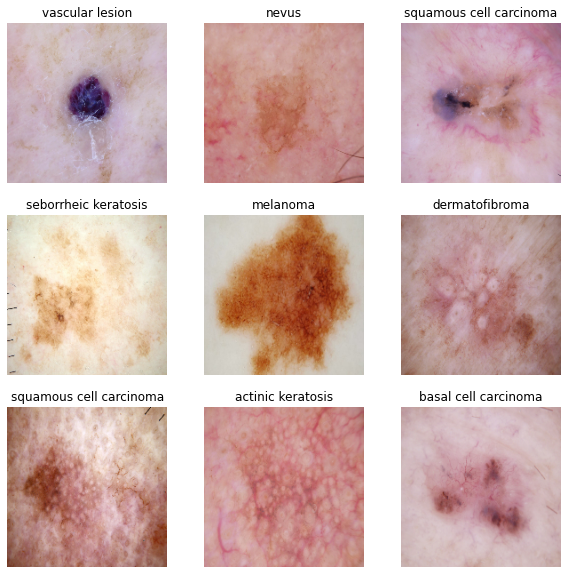

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [11]:
for image_batch,labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break
  

(32, 180, 180, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Model Building & training
### Created a CNN model, which can accurately detect 9 classes present in the dataset.
### Defined appropriate optimiser and loss function for model training.
### Trained the model for ~20 epochs.
### Explained the findings after the model fit with evidence if the model overfits or underfits.
####  Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [13]:
## your code goes here
normalization = layers.experimental.preprocessing.Rescaling(1./255)

In [14]:
### Builing a Model

num_classes=9

model = Sequential()
#Adding a  preprocessing_layers to rescale the inputs
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height,img_width,3)))
model.add(Conv2D(16,kernel_size=(3,3),padding='same',strides=(1,1),activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(32,kernel_size=(3,3),padding='same',strides=(1,1),activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64,kernel_size=(3,3),padding='same',strides=(1,1),activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(128, activation='softmax'))
model.add(Dense(num_classes))


## Number of classes is 9
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 module_wrapper (ModuleWrapp  (None, 180, 180, 16)     448       
 er)                                                             
                                                                 
 module_wrapper_1 (ModuleWra  (None, 90, 90, 16)       0         
 pper)                                                           
                                                                 
 module_wrapper_2 (ModuleWra  (None, 90, 90, 32)       4640      
 pper)                                                           
                                                                 
 module_wrapper_3 (ModuleWra  (None, 45, 45, 32)       0         
 pper)                                                  

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [15]:
# Selected an appropirate optimiser 'adam' and loss function 'SparseCategoricalCrossentropy'

optimizer = 'adam'
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])

### Train the model

In [16]:
#Train the model with 20 epochs and batch size =32.
epochs = 20
batch_size = 32

history = model.fit(
  train_ds,steps_per_epoch=2,
  batch_size=batch_size,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
2/2 [==============================] - 4s 1s/step - loss: 2.1894 - accuracy: 0.1719 - val_loss: 2.1666 - val_accuracy: 0.2371
Epoch 2/20
2/2 [==============================] - 1s 860ms/step - loss: 2.1516 - accuracy: 0.2344 - val_loss: 2.1463 - val_accuracy: 0.1902
Epoch 3/20
2/2 [==============================] - 1s 861ms/step - loss: 2.1170 - accuracy: 0.2500 - val_loss: 2.1350 - val_accuracy: 0.2058
Epoch 4/20
2/2 [==============================] - 1s 865ms/step - loss: 2.1324 - accuracy: 0.2656 - val_loss: 2.1336 - val_accuracy: 0.2058
Epoch 5/20
2/2 [==============================] - 1s 875ms/step - loss: 2.1169 - accuracy: 0.2656 - val_loss: 2.1323 - val_accuracy: 0.2058
Epoch 6/20
2/2 [==============================] - 1s 917ms/step - loss: 2.1428 - accuracy: 0.1094 - val_loss: 2.1311 - val_accuracy: 0.2058
Epoch 7/20
2/2 [==============================] - 1s 984ms/step - loss: 2.1470 - accuracy: 0.1875 - val_loss: 2.1299 - val_accuracy: 0.2058
Epoch 8/20
2/2 [=======

### Visualizing training and validation results

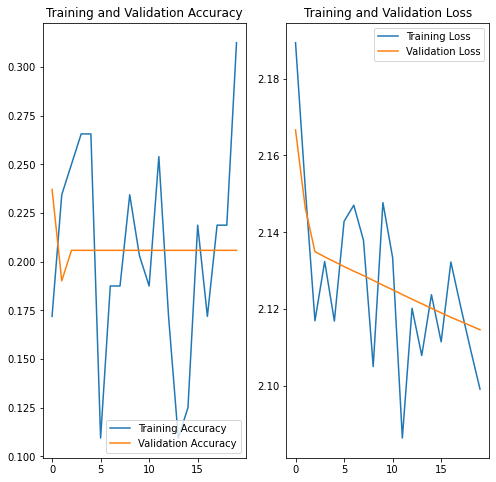

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

#Plotting the training and validation accuracy
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


#Plotting the training and validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


#### Model Overfit or Underfit?

In [18]:
#checking the model accuracy and loss on train and validation dataset
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

14/14 [==============================] - 1s 49ms/step - loss: 2.1146 - accuracy: 0.2058
Accuracy:  0.2065884917974472
Validation Accuracy:  0.20581655204296112
Loss:  2.1113059520721436
Validation Loss 2.114616632461548


### findings
#### Model showing overfit and underfit at certain epochs. but overall model is neither overfit nor underfit and even lossess are less for train and validation data set.We need to chose right data augumentation strategy to improve the accuracy of the model.

# Model with dropout(),BatchNormalization() preprocessed with ImageDataGenerator

### Data Augmentation

In [19]:
#Data Augmentaion using ImageDataGenerator
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

image_class = ['nevus','melanoma','basal_cell_caricoma','actinic_keratosis','vasc_lesion','dermatofibroma', 'pigmented_keratosis', 'seborrheic_keratosis', 'squamous_carci']

train_batches = datagen.flow_from_directory(data_dir_train, 
    target_size = (180,180),
    classes = image_class,
    batch_size = 64
 )

valid_batches = datagen.flow_from_directory(data_dir_test, 
    target_size = (180,180),
    classes = image_class,
    batch_size = 64
)


Found 889 images belonging to 9 classes.
Found 48 images belonging to 9 classes.


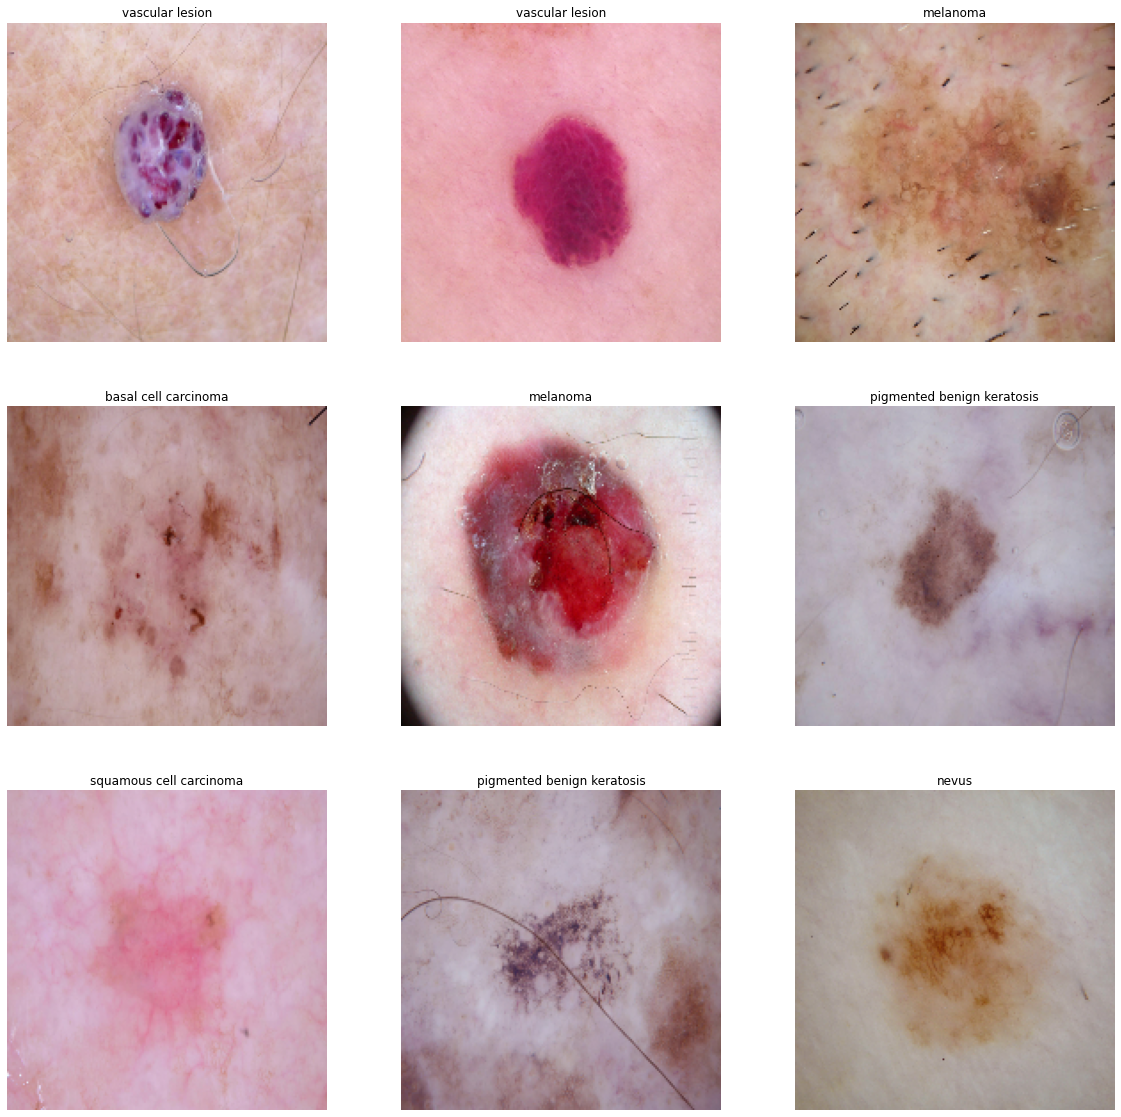

In [20]:
# visualize how your augmentation strategy works for one instance of training image.
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 20))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Creating a model

In [21]:
## Number of classes is 9
num_classes=9

model_1 = Sequential()
#Adding a  preprocessing_layers to rescale the inputs
model_1.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height,img_width,3)))
model_1.add(Conv2D(16,kernel_size=(3,3),padding='same',strides=(1,1),activation='relu'))
model_1.add(MaxPool2D(pool_size=(2, 2)))
# Adding Dropout Layer
model_1.add(Dropout(0.05))

model_1.add(Conv2D(32,kernel_size=(3,3),padding='same',strides=(1,1),activation='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D(pool_size=(2, 2)))
model_1.add(Dropout(0.1))

model_1.add(Conv2D(64,kernel_size=(3,3),padding='same',strides=(2,2),activation='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D(pool_size=(2, 2)))
model_1.add(Dropout(0.15))

model_1.add(Flatten())

model_1.add(Dense(128, activation='softmax'))
model_1.add(Dense(num_classes))

model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 module_wrapper_9 (ModuleWra  (None, 180, 180, 16)     448       
 pper)                                                           
                                                                 
 module_wrapper_10 (ModuleWr  (None, 90, 90, 16)       0         
 apper)                                                          
                                                                 
 module_wrapper_11 (ModuleWr  (None, 90, 90, 16)       0         
 apper)                                                          
                                                                 
 module_wrapper_12 (ModuleWr  (None, 90, 90, 32)       4640      
 apper)                                               

### Compiling the model

In [22]:
## Selected an appropirate optimiser 'adam' and loss function 'categorical_crossentropy'
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model_1.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

I have used an annealing method of the learning rate (LR) in order to make the optimizer converge faster and closest to the global minimum of the loss function, 

The LR is the step by which the optimizer walks through the 'loss landscape'. The higher LR, the bigger are the steps and the quicker is the convergence. However the sampling is very poor with an high LR and the optimizer could probably fall into a local minima.

In [23]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
    patience=3, 
    verbose=1, 
    factor=0.5, 
    min_lr=0.00001)

### Training the model

In [24]:
#train your model for 20 epochs
epochs = 20
batch_size = 10
history = model_1.fit(train_batches,
                     epochs = epochs,
                      steps_per_epoch=2,
                      verbose = 1, 
                      validation_data=valid_batches, 
                      callbacks=[learning_rate_reduction])

Epoch 1/20
2/2 [==============================] - 6s 4s/step - loss: 6.9306 - accuracy: 0.1406 - val_loss: 2.8267 - val_accuracy: 0.2708 - lr: 0.0010
Epoch 2/20
2/2 [==============================] - 4s 3s/step - loss: 1.7203 - accuracy: 0.3672 - val_loss: 0.9485 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 3/20
2/2 [==============================] - 4s 3s/step - loss: 2.0058 - accuracy: 0.4062 - val_loss: 0.4709 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 4/20
2/2 [==============================] - 4s 3s/step - loss: 7.8375 - accuracy: 0.4959 - val_loss: 0.1368 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 5/20
2/2 [==============================] - ETA: 0s - loss: 5.2187 - accuracy: 0.3984
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
2/2 [==============================] - 4s 3s/step - loss: 5.2187 - accuracy: 0.3984 - val_loss: 1.3700 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 6/20
2/2 [==============================] - 4s 3s/step - loss: 1.6240 - accuracy: 0.500

### Visualizing the results

<built-in method keys of dict object at 0x000002122AAD1100> :


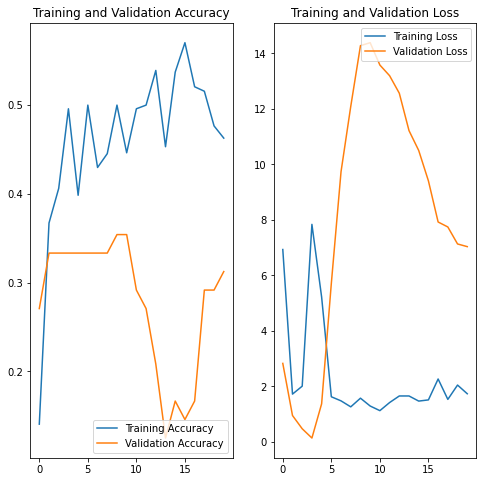

In [25]:
acc = history.history['accuracy']
print(history.history.keys, ":")
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Model Overfit or Underfit?

### Findings
#### Model is a  overfit and even loss has gone higher for train and validation dataset.

## Class distribution

<Figure size 360x360 with 0 Axes>

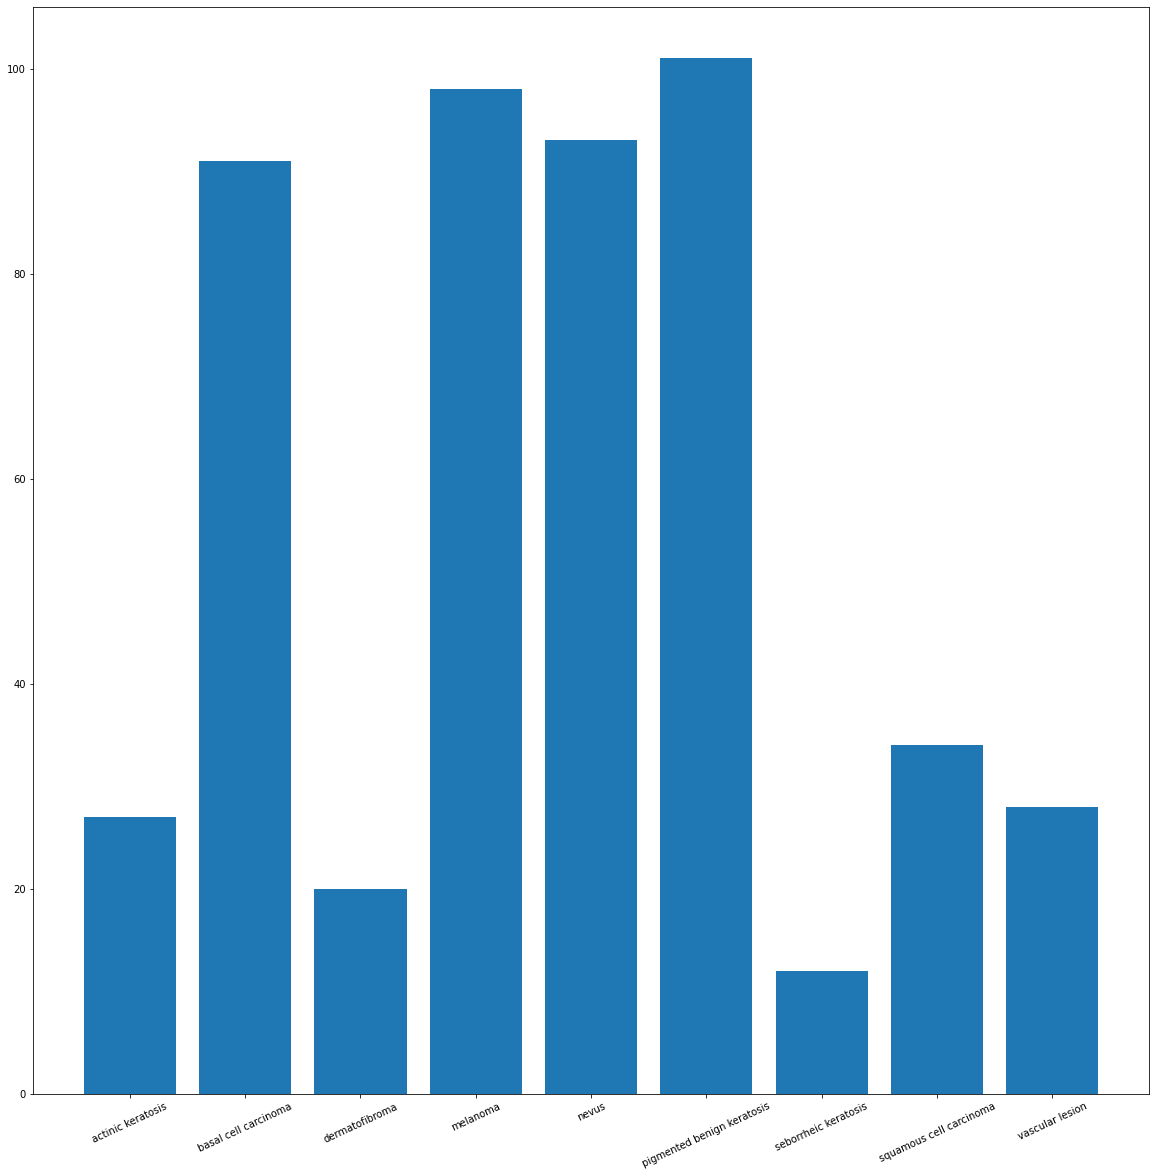

In [27]:
#Plotting the length of the 9 classess of skin disease
import matplotlib.pyplot as plt
data = dict()

for i in class_names:
  data[i] = []

plt.figure(figsize=(5, 5))
for images, labels in train_ds:
  for i in range(9):
    data[class_names[labels[i]]].append(images[i].numpy().astype("uint8"))

for i in data:
  data[i] = len(data[i]) 

f = plt.figure()
f.set_figwidth(20)
f.set_figheight(20)

plt.bar(range(len(data)), list(data.values()), align='center')
plt.xticks(range(len(data)), list(data.keys()))
plt.xticks(rotation = 25)
plt.show()




#### - Which class has the least number of samples? 
**seborrheic keratosis**
#### - Which classes dominate the data in terms proportionate number of samples?
**pigmented benign keratosis** dominates the data of count more than 100 in training


# Managing the Overfit 

### Selected Python package 'Augmentor' an appropriate data augmentation strategy to resolve underfitting/overfitting 

In [28]:
# importing the libraray Augmentor
import Augmentor
for i in class_names:
    csp = str(data_dir_train)
    fullpath = csp + "/" + i
    p = Augmentor.Pipeline(fullpath)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to Train/actinic keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x2122ACC84F0>: 100%|█| 500/500 [00:01<00:


Initialised with 376 image(s) found.
Output directory set to Train/basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x21232FAE8F0>: 100%|█| 500/500 [00:01<00:00, 273.18 Samples


Initialised with 95 image(s) found.
Output directory set to Train/dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2122AC99090>: 100%|█| 500/500 [00:01<00:00, 266.70 Samples


Initialised with 438 image(s) found.
Output directory set to Train/melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x21228F802B0>: 100%|█| 500/500 [00:10<00:00, 49.68 Sample


Initialised with 356 image(s) found.
Output directory set to Train/nevus\output.

Processing <PIL.Image.Image image mode=RGB size=1504x1129 at 0x212290178E0>: 100%|█| 500/500 [00:09<00:00, 54.83 Sample


Initialised with 462 image(s) found.
Output directory set to Train/pigmented benign keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x21232FAF2E0>: 100%|█| 500/500 [00:01<00:


Initialised with 77 image(s) found.
Output directory set to Train/seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x21232F919C0>: 100%|█| 500/500 [00:04<00:00, 107.63 Sample


Initialised with 181 image(s) found.
Output directory set to Train/squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2122AC8C280>: 100%|█| 500/500 [00:01<00:00, 257.82 Samples


Initialised with 139 image(s) found.
Output directory set to Train/vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x21232F93190>: 100%|█| 500/500 [00:02<00:00, 245.98 Samples


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [29]:
#Printing the total count of image
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [30]:
#Creating a new folder 'Output' 
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_4d50e1b6-a862-43a5-a984-0757458156b8.jpg',
 'Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_9e478a7e-5339-4125-8bdc-5646ec0e9afe.jpg',
 'Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_9ede47bf-80e9-4bee-afbd-37f216016d3f.jpg',
 'Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_088b4cd7-c7aa-42fa-9c64-57901883cd05.jpg',
 'Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_1bf7ed56-6b22-4f56-8bf6-fd2eea8fc8e5.jpg',
 'Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_b278c1c0-1c4d-4a04-82f9-1be8e8ba81f5.jpg',
 'Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_d0d07e5f-5b73-4bf8-9d8a-c13f9eff00d3.jpg',
 'Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025953.jpg_6163d7ad-ffeb-4b47-9988-54dcd6ac4a66.jpg',
 'Train\\actinic

In [31]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [32]:

dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [33]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df2

In [34]:
new_df.head()

,Path,Label
0,Train\actinic keratosis\output\actinic keratos...,actinic keratosis
1,Train\actinic keratosis\output\actinic keratos...,actinic keratosis
2,Train\actinic keratosis\output\actinic keratos...,actinic keratosis
3,Train\actinic keratosis\output\actinic keratos...,actinic keratosis
4,Train\actinic keratosis\output\actinic keratos...,actinic keratosis


In [35]:
new_df['Label'].value_counts()

actinic keratosis             500
basal cell carcinoma          500
dermatofibroma                500
melanoma                      500
nevus                         500
pigmented benign keratosis    500
seborrheic keratosis          500
squamous cell carcinoma       500
vascular lesion               500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Create a training dataset

In [36]:
batch_size = 32
img_height = 180
img_width = 180
#data_dir_train="/content/gdrive/MyDrive/CNN/Skin_Data_Store/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6738 files belonging to 9 classes.
Using 5391 files for training.


#### Create a validation dataset

In [37]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6738 files belonging to 9 classes.
Using 1347 files for validation.


# Model Building after data augmentation using library Augmentor
#### Create a model 

In [38]:
model_2 = Sequential()
#Adding a  preprocessing_layers to rescale the inputs
model_2.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height,img_width,3)))
model_2.add(Conv2D(16,kernel_size=(3,3),padding='same',strides=(2,2),activation='relu'))
model_2.add(MaxPool2D(pool_size=(2, 2)))
# Adding Dropout Layer
model_2.add(Dropout(0.05))

model_2.add(Conv2D(32,kernel_size=(3,3),padding='same',strides=(2,2),activation='relu'))
model_2.add(BatchNormalization())
model_2.add(MaxPool2D(pool_size=(2, 2)))
model_2.add(Dropout(0.1))

model_2.add(Conv2D(64,kernel_size=(3,3),padding='same',strides=(2,2),activation='relu'))
model_2.add(BatchNormalization())
model_2.add(MaxPool2D(pool_size=(2, 2)))
model_2.add(Dropout(0.15))

model_2.add(Flatten())

model_2.add(Dense(128, activation='softmax'))
model_2.add(Dense(num_classes))


## Number of classes is 9
model_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 module_wrapper_21 (ModuleWr  (None, 90, 90, 16)       448       
 apper)                                                          
                                                                 
 module_wrapper_22 (ModuleWr  (None, 45, 45, 16)       0         
 apper)                                                          
                                                                 
 module_wrapper_23 (ModuleWr  (None, 45, 45, 16)       0         
 apper)                                                          
                                                                 
 module_wrapper_24 (ModuleWr  (None, 23, 23, 32)       4640      
 apper)                                               

#### Compile your model (Choose optimizer and loss function appropriately)

In [39]:
## Selected an appropirate optimiser 'adam' and loss function 'SparseCategoricalCrossentropy'
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

optimizer = 'adam'
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model_2.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])

####  Train your model

In [40]:
#Training model on 30 epochs with learning_rate_reductions
epochs = 30

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
    patience=3, 
    verbose=1, 
    factor=0.5, 
    min_lr=0.00001)

batch_size = 10
history = model_2.fit(train_ds,
                      epochs = epochs,
                      steps_per_epoch =1, 
                      verbose = 1, 
                      validation_data=val_ds, 
                      callbacks=[learning_rate_reduction])

Epoch 1/30
1/1 [==============================] - 2s 2s/step - loss: 2.1957 - accuracy: 0.1250 - val_loss: 2.1968 - val_accuracy: 0.1359 - lr: 0.0010
Epoch 2/30
1/1 [==============================] - 2s 2s/step - loss: 2.1909 - accuracy: 0.1875 - val_loss: 2.1967 - val_accuracy: 0.1359 - lr: 0.0010
Epoch 3/30
1/1 [==============================] - 2s 2s/step - loss: 2.1999 - accuracy: 0.0312 - val_loss: 2.1966 - val_accuracy: 0.1359 - lr: 0.0010
Epoch 4/30
1/1 [==============================] - ETA: 0s - loss: 2.2034 - accuracy: 0.1562
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1/1 [==============================] - 2s 2s/step - loss: 2.2034 - accuracy: 0.1562 - val_loss: 2.1964 - val_accuracy: 0.1359 - lr: 0.0010
Epoch 5/30
1/1 [==============================] - 2s 2s/step - loss: 2.1972 - accuracy: 0.1562 - val_loss: 2.1963 - val_accuracy: 0.1359 - lr: 5.0000e-04
Epoch 6/30
1/1 [==============================] - 2s 2s/step - loss: 2.2020 - accuracy: 0

####  Visualize the model results

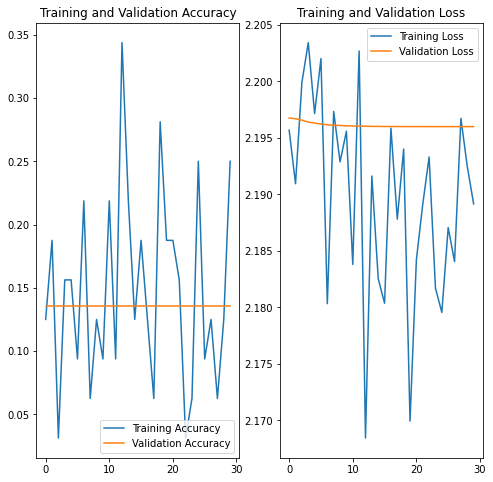

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Is model overfit or underfit

In [42]:
#checking the model accuracy and loss on train and validation dataset
loss, accuracy = model_2.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model_2.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

43/43 [==============================] - 2s 31ms/step - loss: 2.1960 - accuracy: 0.1359
Accuracy:  0.14004823565483093
Validation Accuracy:  0.1358574628829956
Loss:  2.196270704269409
Validation Loss 2.195998430252075


### Findings
#### Managing the class imbalance did  helped in reducing overfit of the model and Loss is also reduced .

#### Did you get rid of underfitting/overfitting? Did class rebalance help?



Managing the class imbalance did  helped in reducing overfit of the data and Loss is also reduced 


Initially we tried without the ImageDataGenerator which lead data to  low accuracy

Then we introduced dropout,batch normalisation and ImageDataGenerator which lead to  overfit

Finallly, we tried manage  the data imbalance with Augumentor which really helped in reducing the loss and also manage the issue of overfit.